## Phase-4: Final


Step-0a: Data Ingestion and Initial Preprocessing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Go to your project folder
%cd /content/drive/MyDrive/multimodal_mammography


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/multimodal_mammography


In [2]:
import importlib.util

def load_module_from_path(name, path):
    spec = importlib.util.spec_from_file_location(name, path)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    return module


In [3]:
# Load environment setup
env = load_module_from_path("env", "setup/environment.py")
install = load_module_from_path("install", "setup/install_colab.py")
_ = load_module_from_path("imports", "setup/imports.py")  # No functions to call

# Run setup
install.install_dependencies()
env.suppress_warnings()
env.set_seed(42)
device = env.get_device()


🔄 Detected Google Colab environment.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted.
📦 Installing required packages...
✅ Dependencies installed.
 Warnings suppressed.
🔁 Seed set to 42
 Using device: cuda


Step-0b: Loading Required csvs' and extracting/exploring images


In [4]:
# ✅ Load the dynamic module
data_loader = load_module_from_path("data_loader", "data/load_data.py")

# ✅ Correct CSV paths
metadata_path    = "/content/drive/MyDrive/multimodal_mammography/dataset/csv/metadata.csv"
breast_anno_path = "/content/drive/MyDrive/multimodal_mammography/dataset/csv/breast-level_annotations.csv"
finding_anno_path = "/content/drive/MyDrive/multimodal_mammography/dataset/csv/finding_annotations.csv"

# ✅ Load and view data
metadata_df, breast_df, finding_df = data_loader.load_mammo_data(
    metadata_path,
    breast_anno_path,
    finding_anno_path,
    verbose=False
)


In [5]:
import pandas as pd

image_df=pd.read_csv("/content/drive/MyDrive/multimodal_mammography/dataset/csv/image_df_upsampled_studywise.csv")

In [6]:
print(image_df.columns)

Index(['image_id', 'study_id', 'filename', 'birads', 'birads_dir', 'density',
       'laterality', 'view_position', 'split', 'finding_categories',
       'finding_birads_clean', 'xmin', 'ymin', 'xmax', 'ymax', 'has_bbox',
       'age', 'birads_binary', 'birads_cleaned', 'birads_study_level',
       'finding_mass', 'finding_suspicious_calcification',
       'finding_focal_asymmetry', 'finding_asymmetry',
       'finding_global_asymmetry', 'finding_architectural_distortion',
       'finding_skin_thickening', 'finding_skin_retraction',
       'finding_nipple_retraction', 'finding_suspicious_lymph_node',
       'finding_no_finding', 'image_path', 'case_category', 'upsampled'],
      dtype='object')


In [7]:
import zipfile
import os

# Path to your zip file
zip_path = "/content/drive/MyDrive/multimodal_mammography/dataset/zipped_folder/birads_preprocessed_dataset.zip"

# Destination folder to extract files
extract_dir = "/content/birads_preprocessed_dataset"

# Make sure the directory exists
os.makedirs(extract_dir, exist_ok=True)

# Unzip the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extraction complete.")
print("Extracted to:", extract_dir)


Extraction complete.
Extracted to: /content/birads_preprocessed_dataset


In [8]:
import os

# List a few extracted files/folders
for root, dirs, files in os.walk(extract_dir):
    print("Root:", root)
    print("Subdirs:", dirs[:5])   # show first 5 dirs
    print("Files:", files[:5])   # show first 5 files
    break


Root: /content/birads_preprocessed_dataset
Subdirs: ['test', 'training']
Files: ['image_df_upsampled_preprocessed.csv']


Step-0c: Validating existing dataset


In [9]:
import os
from collections import defaultdict

base_dir = "/content/birads_preprocessed_dataset"

def find_small_studies(base_dir, min_images=4):
    small_studies = defaultdict(list)

    for split in ["training", "test"]:
        for case in ["normal", "abnormal"]:
            case_path = os.path.join(base_dir, split, case)
            if not os.path.exists(case_path):
                continue

            for study in os.listdir(case_path):
                study_path = os.path.join(case_path, study)
                if not os.path.isdir(study_path):
                    continue

                imgs = [f for f in os.listdir(study_path) if f.endswith(".png")]
                if len(imgs) < min_images:
                    small_studies[(split, case, study)] = imgs

    return small_studies

small_studies = find_small_studies(base_dir)

if small_studies:
    print("⚠️ Studies with fewer than 4 images:")
    for (split, case, study), imgs in small_studies.items():
        print(f"- {split}/{case}/{study} -> {len(imgs)} images: {imgs}")
else:
    print("✅ All studies have at least 4 images.")


✅ All studies have at least 4 images.


In [10]:
import os
from collections import Counter

base_dir = "/content/birads_preprocessed_dataset"
splits = ["training", "test"]
classes = ["normal", "abnormal"]

# Dictionary to store study -> image count
study_image_counts = {}

for split in splits:
    split_path = os.path.join(base_dir, split)
    for cls in classes:
        cls_path = os.path.join(split_path, cls)
        if not os.path.exists(cls_path):
            continue
        for study in os.listdir(cls_path):
            study_path = os.path.join(cls_path, study)
            if os.path.isdir(study_path):
                images = [f for f in os.listdir(study_path) if f.endswith(".png")]
                study_image_counts[study] = len(images)

# Summarize the distribution of images per study
count_distribution = Counter(study_image_counts.values())
print("Image count per study distribution:")
for n_images, n_studies in sorted(count_distribution.items()):
    print(f"{n_images} images: {n_studies} studies")

# Optional: total studies
print(f"\nTotal studies counted: {len(study_image_counts)}")


Image count per study distribution:
4 images: 7999 studies

Total studies counted: 7999


In [11]:
import os
import pandas as pd
from tqdm import tqdm  # import tqdm

# Paths
base_dir = "/content/birads_preprocessed_dataset"
original_csv = os.path.join(base_dir, "image_df_upsampled_preprocessed.csv")
fixed_csv = os.path.join(base_dir, "image_df_preprocessed_fixed.csv")

# Load original CSV
df_orig = pd.read_csv(original_csv)

# Ensure string types for safe matching
df_orig["study_id"] = df_orig["study_id"].astype(str)
df_orig["filename"] = df_orig["filename"].astype(str)

# Prepare list for final rows
rows = []

splits = ["training", "test"]
classes = ["normal", "abnormal"]

for split in splits:
    split_path = os.path.join(base_dir, split)
    if not os.path.exists(split_path):
        continue

    for cls in classes:
        cls_path = os.path.join(split_path, cls)
        if not os.path.exists(cls_path):
            continue

        study_list = [s for s in os.listdir(cls_path) if os.path.isdir(os.path.join(cls_path, s))]
        for study in tqdm(study_list, desc=f"{split}/{cls} studies"):
            study_path = os.path.join(cls_path, study)

            images = sorted([f for f in os.listdir(study_path) if f.endswith(".png")])
            if len(images) != 4:
                continue  # only keep studies with exactly 4 images

            for img in images:
                # Try to get metadata from original CSV
                match = df_orig[(df_orig["study_id"] == study) &
                                (df_orig["filename"] == img)]
                if not match.empty:
                    row = match.iloc[0].copy()
                    row["image_path"] = os.path.join(study_path, img)  # update path
                else:
                    # If missing in original CSV, create minimal row with placeholders
                    row = {col: -1 for col in df_orig.columns}  # -1 as placeholder
                    row["study_id"] = study
                    row["filename"] = img
                    row["image_path"] = os.path.join(study_path, img)
                    row["split"] = split
                    row["case_category"] = cls

                rows.append(row)

# Build DataFrame
df_fixed = pd.DataFrame(rows)

# Save CSV
df_fixed.to_csv(fixed_csv, index=False)

# Summary
print(f"✅ Fixed CSV saved at: {fixed_csv}")
print(f"Total studies included: {df_fixed['study_id'].nunique()}")
print(f"Total images included: {len(df_fixed)}")


test/abnormal studies: 100%|██████████| 84/84 [00:01<00:00, 45.79it/s]


✅ Fixed CSV saved at: /content/birads_preprocessed_dataset/image_df_preprocessed_fixed.csv
Total studies included: 7999
Total images included: 31996


In [12]:
print(df_fixed.columns)

Index(['image_id', 'study_id', 'filename', 'birads', 'birads_dir', 'density',
       'laterality', 'view_position', 'split', 'finding_categories',
       'finding_birads_clean', 'xmin', 'ymin', 'xmax', 'ymax', 'has_bbox',
       'age', 'birads_binary', 'birads_cleaned', 'birads_study_level',
       'finding_mass', 'finding_suspicious_calcification',
       'finding_focal_asymmetry', 'finding_asymmetry',
       'finding_global_asymmetry', 'finding_architectural_distortion',
       'finding_skin_thickening', 'finding_skin_retraction',
       'finding_nipple_retraction', 'finding_suspicious_lymph_node',
       'finding_no_finding', 'image_path', 'case_category', 'upsampled',
       'preprocessed_path'],
      dtype='object')


In [13]:
import os
import pandas as pd

# Paths
base_dir = "/content/birads_preprocessed_dataset"
csv_path = os.path.join(base_dir, "image_df_preprocessed_fixed.csv")

# Load CSV metadata
df = pd.read_csv(csv_path)

# Build sets for quick lookup
expected_study_ids = set(df["study_id"].astype(str).unique())
expected_image_ids = set(df["image_id"].astype(str).unique())

issues = []

# Iterate over splits and classes
for split in ["training", "test"]:
    for cls in ["normal", "abnormal"]:
        cls_path = os.path.join(base_dir, split, cls)
        if not os.path.exists(cls_path):
            issues.append(f"Missing folder: {cls_path}")
            continue

        # Iterate over studies
        for study in os.listdir(cls_path):
            study_path = os.path.join(cls_path, study)
            if not os.path.isdir(study_path):
                continue

            # Validate study ID
            if study not in expected_study_ids:
                issues.append(f"Study folder '{study}' not found in CSV")

            # Validate image files
            for img in os.listdir(study_path):
                if img.endswith(".png"):
                    img_id = os.path.splitext(img)[0]  # remove extension
                    if img_id not in expected_image_ids:
                        issues.append(f"Image '{img}' in '{study_path}' not found in CSV")

# Summary
if not issues:
    print("✅ Dataset structure matches CSV metadata and is valid.")
else:
    print("⚠️ Issues found:")
    for issue in issues:
        print("-", issue)


✅ Dataset structure matches CSV metadata and is valid.


In [14]:
import pandas as pd
import os

# Paths
base_dir = "/content/birads_preprocessed_dataset"
csv_path = os.path.join(base_dir, "image_df_preprocessed_fixed.csv")

# Load CSV
df = pd.read_csv(csv_path)

# Iterate over all columns and print unique values and counts
for col in df.columns:
    unique_vals = df[col].nunique()
    print(f"{col}: {unique_vals} unique values")
    # Optionally, show top 10 most frequent values
    print(df[col].value_counts().head(10))
    print("-" * 50)


image_id: 19996 unique values
image_id
2bd9c72b886e97da1aff1361962c6acc    24
2973bcf878fad1e9edade25be62602ce    24
6266ffa44d75d2edc9d3c725b20b6d49    24
7dbf6830cc06730cfe74cd58937f89a8    24
a7acc2e02a4944c4fc72e32507b17fa7    22
85a6579cbdc403cfc4dde0a8149ed855    22
3cd51ee99070c4d625d52b848d5e9bfc    22
10e0f362333df810ac84a9db8fb3fd42    22
c0d6b03b2add28581aec656ad0d10613    21
b0124dae990a237fc01f625feea67a52    21
Name: count, dtype: int64
--------------------------------------------------
study_id: 7999 unique values
study_id
a1f8c1d32ac2da1967b3c6b3ee34616e             4
41aabf1214439580e6ab7b4d23a836e2_dup1794     4
ddb45d8f34c980e3bcf07ff518af7eec             4
0e32dd9f5b09d5e474a378f75611b3d7             4
a112384eeb503e4e1ba00981eda464e8             4
26f9cf5d9a3d563c88a816f7a1abedaa_dup11636    4
163e112d5af21e69707b9214ee2ebda0_dup11915    4
fd95d3a7bd6692f0d5c1785a810b8e1b             4
f132348fba403645b37cd96ad4deaa70             4
aafeb37d07132ba4d84b8836daa8f56f_

Step-1: Feature Engineering

In [15]:
import pandas as pd
import os
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Paths
base_dir = "/content/birads_preprocessed_dataset"
csv_path = os.path.join(base_dir, "image_df_preprocessed_fixed.csv")
output_csv_path = os.path.join(base_dir, "study_level_metadata.csv")

# Load CSV
df = pd.read_csv(csv_path)

# Keep only study-level rows (drop image duplicates)
df_study = df.drop_duplicates(subset=["study_id"]).reset_index(drop=True)

# Target variable
df_study["birads_binary_num"] = df_study["birads_binary"].map({"normal": 0, "abnormal": 1})

# Features: age + density only
num_features = ["age"]
cat_features = ["density"]

X = df_study[num_features + cat_features]

# Preprocessing: scale numeric + one-hot encode categorical (keep all categories)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(drop=None, sparse_output=False), cat_features),
    ]
)

# Apply preprocessing
X_processed = preprocessor.fit_transform(X)

# Get one-hot density column names
density_cols = preprocessor.named_transformers_["cat"].get_feature_names_out(cat_features)

# Build final DataFrame
import numpy as np
df_final = pd.DataFrame(
    np.hstack([X_processed, df_study["birads_binary_num"].values.reshape(-1, 1)]),
    columns=list(num_features) + list(density_cols) + ["birads_binary"]
)

# Add study_id for reference
df_final["study_id"] = df_study["study_id"].values

# Reorder columns: study_id first
df_final = df_final[["study_id"] + list(num_features) + list(density_cols) + ["birads_binary"]]

# Save to CSV
df_final.to_csv(output_csv_path, index=False)

print("Final study-level CSV saved to:", output_csv_path)
print("Shape:", df_final.shape)
print("Columns:", df_final.columns.tolist())


Final study-level CSV saved to: /content/birads_preprocessed_dataset/study_level_metadata.csv
Shape: (7999, 7)
Columns: ['study_id', 'age', 'density_A', 'density_B', 'density_C', 'density_D', 'birads_binary']


Step-2: Model Result based on only metadata

In [16]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    accuracy_score, f1_score, brier_score_loss
)
import xgboost as xgb

# Paths
base_dir = "/content/birads_preprocessed_dataset"
csv_path = os.path.join(base_dir, "study_level_metadata.csv")

# Load study-level dataset
df = pd.read_csv(csv_path)

# Features and target
feature_cols = [col for col in df.columns if col not in ["study_id", "birads_binary"]]
X = df[feature_cols].values
y = df["birads_binary"].values
study_ids = df["study_id"].values

print("Raw features shape:", X.shape)

# Study-wise split
train_ids, test_ids, y_train_ids, y_test_ids = train_test_split(
    study_ids, y, test_size=0.125, random_state=42, stratify=y
)
train_ids, val_ids, y_train_ids, y_val_ids = train_test_split(
    train_ids, y_train_ids, test_size=0.2, random_state=42, stratify=y_train_ids
)

# Masks for indexing
train_mask = np.isin(study_ids, train_ids)
val_mask = np.isin(study_ids, val_ids)
test_mask = np.isin(study_ids, test_ids)

X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]
X_test, y_test = X[test_mask], y[test_mask]

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# -------------------------------
# Logistic Regression
# -------------------------------
logreg = LogisticRegression(max_iter=500, class_weight="balanced", solver="liblinear")
logreg.fit(X_train, y_train)

y_val_pred = logreg.predict_proba(X_val)[:, 1]
y_test_pred = logreg.predict_proba(X_test)[:, 1]

print("\n=== Logistic Regression ===")
print(f"Val AUROC: {roc_auc_score(y_val, y_val_pred):.4f}")
print(f"Val AUPRC: {average_precision_score(y_val, y_val_pred):.4f}")
print(f"Test AUROC: {roc_auc_score(y_test, y_test_pred):.4f}")
print(f"Test AUPRC: {average_precision_score(y_test, y_test_pred):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, (y_test_pred > 0.5)):.4f}")
print(f"Test F1: {f1_score(y_test, (y_test_pred > 0.5)):.4f}")
print(f"Test Brier Score: {brier_score_loss(y_test, y_test_pred):.4f}")

# -------------------------------
# XGBoost
# -------------------------------
xgb_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    use_label_encoder=False,
    random_state=42,
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05
)

xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

y_val_pred = xgb_model.predict_proba(X_val)[:, 1]
y_test_pred = xgb_model.predict_proba(X_test)[:, 1]

print("\n=== XGBoost ===")
print(f"Val AUROC: {roc_auc_score(y_val, y_val_pred):.4f}")
print(f"Val AUPRC: {average_precision_score(y_val, y_val_pred):.4f}")
print(f"Test AUROC: {roc_auc_score(y_test, y_test_pred):.4f}")
print(f"Test AUPRC: {average_precision_score(y_test, y_test_pred):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, (y_test_pred > 0.5)):.4f}")
print(f"Test F1: {f1_score(y_test, (y_test_pred > 0.5)):.4f}")
print(f"Test Brier Score: {brier_score_loss(y_test, y_test_pred):.4f}")


Raw features shape: (7999, 5)
Train: (5599, 5), Val: (1400, 5), Test: (1000, 5)

=== Logistic Regression ===
Val AUROC: 0.5696
Val AUPRC: 0.3281
Test AUROC: 0.5821
Test AUPRC: 0.3305
Test Accuracy: 0.5420
Test F1: 0.3910
Test Brier Score: 0.2457

=== XGBoost ===
Val AUROC: 0.6831
Val AUPRC: 0.4324
Test AUROC: 0.6782
Test AUPRC: 0.4552
Test Accuracy: 0.6490
Test F1: 0.4706
Test Brier Score: 0.2228


Step-3: Setting up environment

In [17]:
import torch
import numpy as np
import random
import os

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


Step-5: Creating fusion level dataset

In [18]:
import pandas as pd
import os
from sklearn.preprocessing import OneHotEncoder

# ----------------------------
# Paths
# ----------------------------
base_dir = "/content/birads_preprocessed_dataset"
csv_path = os.path.join(base_dir, "image_df_preprocessed_fixed.csv")

# ----------------------------
# Load CSV and map labels
# ----------------------------
df = pd.read_csv(csv_path)
df["birads_binary"] = df["birads_binary"].map({"normal": 0, "abnormal": 1})

# ----------------------------
# Keep only complete studies and map images
# ----------------------------
study_groups = []
for study_id, group in df.groupby("study_id"):
    if len(group) == 4:  # L-CC, L-MLO, R-CC, R-MLO
        row = group.iloc[0].copy()  # representative row
        row["study_id"] = study_id

        # Assign split and case_category from first row
        row["split"] = group["split"].iloc[0]
        row["case_category"] = group["case_category"].iloc[0]

        # Map image paths and indices
        for idx, img_row in enumerate(group.itertuples()):
            pos_col_path = f"{img_row.laterality}_{img_row.view_position}_path"
            pos_col_idx  = f"{img_row.laterality}_{img_row.view_position}_idx"
            row[pos_col_path] = img_row.image_path
            row[pos_col_idx]  = idx  # 0-3 index within study

        study_groups.append(row)

fusion_df = pd.DataFrame(study_groups)

# ----------------------------
# One-hot encode density
# ----------------------------
ohe = OneHotEncoder(drop=None, sparse_output=False)
density_encoded = ohe.fit_transform(fusion_df[["density"]])
density_cols = ohe.get_feature_names_out(["density"])
density_df = pd.DataFrame(density_encoded, columns=density_cols)

# ----------------------------
# Build final study-level DataFrame
# ----------------------------
final_cols = ["study_id", "age", "birads_binary", "split", "case_category"]
# Collect all image path and index columns
image_path_cols = [col for col in fusion_df.columns if col.endswith("_path")]
image_idx_cols  = [col for col in fusion_df.columns if col.endswith("_idx")]

final_df = pd.concat([
    fusion_df[final_cols].reset_index(drop=True),
    density_df.reset_index(drop=True),
    fusion_df[image_path_cols + image_idx_cols].reset_index(drop=True)
], axis=1)

# ----------------------------
# Save CSV
# ----------------------------
final_csv_path = os.path.join(base_dir, "study_level_metadata.csv")
final_df.to_csv(final_csv_path, index=False)

print("Final study-level CSV saved to:", final_csv_path)
print("Shape:", final_df.shape)
print("Columns:", final_df.columns.tolist())


Final study-level CSV saved to: /content/birads_preprocessed_dataset/study_level_metadata.csv
Shape: (7999, 19)
Columns: ['study_id', 'age', 'birads_binary', 'split', 'case_category', 'density_A', 'density_B', 'density_C', 'density_D', 'image_path', 'preprocessed_path', 'L_MLO_path', 'L_CC_path', 'R_MLO_path', 'R_CC_path', 'L_MLO_idx', 'L_CC_idx', 'R_MLO_idx', 'R_CC_idx']


In [19]:
print(final_df.head())

                                    study_id  age  birads_binary     split  \
0           0025a5dc99fd5c742026f0b2b030d3e9   44              0      test   
1           0028fb2c7f0b3a5cb9a80cb0e1cdbb91   51              0  training   
2           0034765af074f93ed33d5e8399355caf   37              0  training   
3           003700f3c960e0b9bca2b8437c3dbf05   44              0  training   
4  003700f3c960e0b9bca2b8437c3dbf05_dup11243   44              0  training   

   case_category  density_A  density_B  density_C  density_D  \
0              0        0.0        0.0        1.0        0.0   
1              0        0.0        0.0        1.0        0.0   
2              0        0.0        0.0        1.0        0.0   
3              1        0.0        0.0        1.0        0.0   
4              1        0.0        0.0        1.0        0.0   

                                          image_path  \
0  /content/birads_preprocessed_dataset/test/norm...   
1  /content/birads_preprocessed_da

In [20]:
import pandas as pd
import os

# ----------------------------
# Load original study-level CSV (fusion CSV)
# ----------------------------
study_csv_path = "/content/birads_preprocessed_dataset/study_level_metadata.csv"
study_df = pd.read_csv(study_csv_path)

# ----------------------------
# Load image_df for comparison
# ----------------------------
image_df_path = "/content/drive/MyDrive/multimodal_mammography/dataset/csv/image_df_upsampled_studywise.csv"
image_df = pd.read_csv(image_df_path)

# ----------------------------
# 1️⃣ Check study counts
# ----------------------------
print("Total studies in study_level_metadata.csv:", len(study_df))
print("Unique studies in image_df:", image_df['study_id'].nunique())

# ----------------------------
# 2️⃣ Validate that each study has 4 images
# ----------------------------
# Count images per study in image_df
study_counts = image_df.groupby("study_id")["image_id"].count()
incomplete_studies = study_counts[study_counts != 4]
print("Incomplete studies in image_df (should be 0):", len(incomplete_studies))

# ----------------------------
# 3️⃣ Validate that paths exist in filesystem
# ----------------------------
missing_paths = []
for col in [c for c in study_df.columns if c.endswith("_path")]:
    for p in study_df[col]:
        if not os.path.exists(p):
            missing_paths.append(p)
print("Missing image files in study_level_metadata.csv:", len(missing_paths))

# ----------------------------
# 4️⃣ Optional: Check all studies match
# ----------------------------
merged = pd.merge(study_df[['study_id']], image_df[['study_id']].drop_duplicates(), on='study_id', how='outer', indicator=True)
print("Studies only in study_level_metadata.csv:", merged[merged['_merge']=='left_only'].shape[0])
print("Studies only in image_df:", merged[merged['_merge']=='right_only'].shape[0])


Total studies in study_level_metadata.csv: 7999
Unique studies in image_df: 7999
Incomplete studies in image_df (should be 0): 0
Missing image files in study_level_metadata.csv: 0
Studies only in study_level_metadata.csv: 0
Studies only in image_df: 0


Step-5: Multimodal Class and Dataloader

In [21]:
import torch
print(torch.cuda.is_available())  # Should be True
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(torch.cuda.current_device()))


True
0
Tesla T4


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)  # should print cuda


cuda


In [23]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, Sampler
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from collections import defaultdict, Counter
from tqdm import tqdm

# ----------------------------
# Device (used only in training loop)
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ----------------------------
# Paths
# ----------------------------
BASE_DIR = "/content/birads_preprocessed_dataset"
CSV_PATH = os.path.join(BASE_DIR, "study_level_metadata.csv")
AUG_SAVE_DIR = os.path.join(BASE_DIR, "augmented_tensors")
os.makedirs(AUG_SAVE_DIR, exist_ok=True)

# ----------------------------
# Load CSV
# ----------------------------
df = pd.read_csv(CSV_PATH)
df["birads_binary"] = df["birads_binary"].astype(int)

# ----------------------------
# Metadata columns (exclude case_category)
# ----------------------------
metadata_cols = ["age", "density_A", "density_B", "density_C", "density_D"]

# ----------------------------
# Image transforms
# ----------------------------
TRAIN_TRANSFORMS = T.Compose([
    T.Grayscale(num_output_channels=3),
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(20),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.ToTensor(),
    T.Normalize([0.485, 0.485, 0.485], [0.229, 0.229, 0.229])
])

VAL_TRANSFORMS = T.Compose([
    T.Grayscale(num_output_channels=3),
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.485, 0.485, 0.485], [0.229, 0.229, 0.229])
])

# ----------------------------
# Dataset
# ----------------------------
class MammogramStudyDataset(Dataset):
    """
    Study-level dataset returning:
      - images: Tensor (4, 3, H, W) in CPU (no device transfer here)
      - metadata: Tensor (metadata_dim,) in CPU
      - label: Tensor scalar (long) in CPU
    Expects df to contain columns:
      - study_id
      - split (values like 'training' / 'test' etc.)
      - L_CC_path, L_MLO_path, R_CC_path, R_MLO_path
      - birads_binary
      - metadata columns (as defined in metadata_cols)
    """
    def __init__(self, df, split="training", transform=None, metadata_cols=None, placeholder_size=(3,224,224)):
        self.df_split = df[df["split"] == split].copy().reset_index(drop=True)
        self.transform = transform
        self.metadata_cols = metadata_cols or []
        self.placeholder_image = torch.zeros(placeholder_size, dtype=torch.float32)

        # Build study-level dict for fast indexing (keeps data in CPU)
        self.study_groups = {}
        for _, row in tqdm(self.df_split.iterrows(), total=len(self.df_split), desc=f"Loading {split} studies"):
            images = {
                "L_CC": row.get("L_CC_path", None),
                "L_MLO": row.get("L_MLO_path", None),
                "R_CC": row.get("R_CC_path", None),
                "R_MLO": row.get("R_MLO_path", None),
            }
            # Ensure metadata ordering matches metadata_cols
            metadata = row[self.metadata_cols].values.astype(np.float32) if len(self.metadata_cols) > 0 else np.array([], dtype=np.float32)
            self.study_groups[row["study_id"]] = {
                "images": images,
                "metadata": metadata,
                "label": int(row["birads_binary"])
            }

        # list of study ids (will be subsetted externally for train/val splits)
        self.study_ids = list(self.study_groups.keys())

    def __len__(self):
        return len(self.study_ids)

    def __getitem__(self, idx):
        study_id = self.study_ids[idx]
        study = self.study_groups[study_id]
        images = []
        for view in ["L_CC", "L_MLO", "R_CC", "R_MLO"]:
            path = study["images"].get(view)
            if path and isinstance(path, str) and os.path.exists(path):
                img = Image.open(path).convert("RGB")
                if self.transform is not None:
                    img = self.transform(img)
                # transform returns torch.Tensor
            else:
                # placeholder (already a tensor)
                img = self.placeholder_image.clone()
            images.append(img)

        # Stack so shape is (4, C, H, W)
        images = torch.stack(images, dim=0)  # CPU tensors

        # Small gaussian noise for numeric metadata (CPU)
        if len(self.metadata_cols) > 0:
            metadata = torch.tensor(study["metadata"], dtype=torch.float32) + torch.randn(len(self.metadata_cols), dtype=torch.float32) * 0.01
        else:
            metadata = torch.tensor([], dtype=torch.float32)

        label = torch.tensor(study["label"], dtype=torch.long)

        # NOTE: Do NOT move to GPU here. Keep CPU tensors; move in training loop.
        return images, metadata, label

# ----------------------------
# Balanced Oversampling Sampler
# ----------------------------
class BalancedSampler(Sampler):
    """
    Oversample minority class to match majority class count.
    Uses dataset.study_ids and dataset.study_groups to derive labels.
    """
    def __init__(self, dataset, seed=42):
        self.dataset = dataset
        random.seed(seed)

        # Build label -> indices mapping based on current dataset.study_ids
        self.label_indices = defaultdict(list)
        for idx, sid in enumerate(self.dataset.study_ids):
            lbl = int(self.dataset.study_groups[sid]["label"])
            self.label_indices[lbl].append(idx)

        # If only one class present, just return its indices
        if len(self.label_indices) == 0:
            self.indices = []
        else:
            max_count = max(len(v) for v in self.label_indices.values())
            # Oversample minority classes
            for lbl, idx_list in list(self.label_indices.items()):
                curr_len = len(idx_list)
                if curr_len == 0:
                    continue
                reps = max_count - curr_len
                if reps > 0:
                    self.label_indices[lbl].extend(random.choices(idx_list, k=reps))
                random.shuffle(self.label_indices[lbl])

            # Flatten and shuffle across classes
            self.indices = []
            for lbl in sorted(self.label_indices.keys()):
                self.indices.extend(self.label_indices[lbl])
            random.shuffle(self.indices)

    def __iter__(self):
        return iter(self.indices)

    def __len__(self):
        return len(self.indices)

# ----------------------------
# Create datasets (initial)
# ----------------------------
train_dataset = MammogramStudyDataset(df, split="training", transform=TRAIN_TRANSFORMS, metadata_cols=metadata_cols)
# create copy for val (same split but we will subset study_ids)
val_dataset = MammogramStudyDataset(df, split="training", transform=VAL_TRANSFORMS, metadata_cols=metadata_cols)
test_dataset = MammogramStudyDataset(df, split="test", transform=VAL_TRANSFORMS, metadata_cols=metadata_cols)

# ----------------------------
# Manual train/val split (split study_ids of the training set)
# ----------------------------
train_ids, val_ids = train_test_split(train_dataset.study_ids, test_size=0.2, random_state=42, stratify=[train_dataset.study_groups[sid]["label"] for sid in train_dataset.study_ids])
train_dataset.study_ids = train_ids
val_dataset.study_ids = val_ids

# ----------------------------
# Dataloaders (create sampler after train_dataset.study_ids set)
# ----------------------------
batch_size = 4
num_workers = 2  # set to 0 if you face issues in certain environments

train_sampler = BalancedSampler(train_dataset)
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

# ----------------------------
# Print label balance (after split)
# ----------------------------
counts = Counter([train_dataset.study_groups[sid]["label"] for sid in train_dataset.study_ids])
print("Training label distribution (after split):", counts)

# ----------------------------
# Optional: Save augmented tensors to disk (CPU tensors)
# ----------------------------
SAVE_AUGMENTED = True
if SAVE_AUGMENTED:
    for split_name, dataset in [("train", train_dataset), ("val", val_dataset), ("test", test_dataset)]:
        split_dir = os.path.join(AUG_SAVE_DIR, split_name)
        os.makedirs(split_dir, exist_ok=True)
        for sid in tqdm(dataset.study_ids, desc=f"Saving {split_name} tensors"):
            idx = dataset.study_ids.index(sid)
            images, metadata, label = dataset[idx]  # CPU tensors
            fname = os.path.join(split_dir, f"{sid}.pt")
            torch.save({"images": images, "metadata": metadata, "label": label}, fname)

# ----------------------------
# Test first batch (demonstrates how to move to device in main process)
# ----------------------------
for imgs_cpu, metadata_cpu, labels_cpu in train_loader:
    # Move batch to device here (main process) — safe with DataLoader multiprocessing
    imgs = imgs_cpu.to(device, non_blocking=True)        # shape: [B, 4, 3, H, W]
    metadata = metadata_cpu.to(device, non_blocking=True)
    labels = labels_cpu.to(device, non_blocking=True)

    print("Batch images (device):", imgs.shape, imgs.dtype, imgs.device)
    print("Batch metadata (device):", metadata.shape, metadata.dtype, metadata.device)
    print("Batch labels (device):", labels.shape, labels.dtype, labels.device)
    break


Using device: cuda


Loading test studies: 100%|██████████| 1000/1000 [00:00<00:00, 3049.82it/s]


Training label distribution (after split): Counter({0: 4011, 1: 1588})


Saving test tensors: 100%|██████████| 1000/1000 [02:07<00:00,  7.82it/s]


Batch images (device): torch.Size([4, 4, 3, 224, 224]) torch.float32 cuda:0
Batch metadata (device): torch.Size([4, 5]) torch.float32 cuda:0
Batch labels (device): torch.Size([4]) torch.int64 cuda:0


In [24]:
from collections import Counter

train_labels = [train_dataset.study_groups[sid]["label"] for sid in train_dataset.study_ids]
case_counts = Counter(train_labels)
print("Training label distribution:", case_counts)


Training label distribution: Counter({0: 4011, 1: 1588})


In [25]:

import shutil
import os

SRC = "/content/birads_preprocessed_dataset/augmented_tensors"
DST = "/content/drive/MyDrive/birads_augmented_tensors"

os.makedirs(DST, exist_ok=True)

# Copy everything (train, val, test folders and all .pt files)
shutil.copytree(SRC, DST, dirs_exist_ok=True)

print(f"✅ All tensors copied to Drive at: {DST}")


✅ All tensors copied to Drive at: /content/drive/MyDrive/birads_augmented_tensors


Step-6: Model Defintion


In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

# ----------------------------
# 1. EfficientNet Backbone
# ----------------------------
class EfficientNetBackbone(nn.Module):
    def __init__(self, pretrained=True, out_dim=1280):
        super().__init__()
        base = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1 if pretrained else None)
        self.features = base.features
        self.out_dim = out_dim

    def forward(self, x):
        return self.features(x)  # [B, C, H, W]

# ----------------------------
# 2. CMDPA with Proper Multi-Head Attention
# ----------------------------
class CMDPAModule(nn.Module):
    def __init__(self, in_channels=1280, reduction=4):
        super().__init__()
        self.query_L = nn.Conv2d(in_channels, in_channels // reduction, 1)
        self.key_R   = nn.Conv2d(in_channels, in_channels // reduction, 1)
        self.value_R = nn.Conv2d(in_channels, in_channels, 1)

        self.query_R = nn.Conv2d(in_channels, in_channels // reduction, 1)
        self.key_L   = nn.Conv2d(in_channels, in_channels // reduction, 1)
        self.value_L = nn.Conv2d(in_channels, in_channels, 1)

        self.softmax = nn.Softmax(dim=-1)

    def cross_attention(self, Q, K, V):
        B, Cq, H, W = Q.shape
        Q_flat = Q.view(B, Cq, -1).permute(0, 2, 1)  # [B, HW, Cq]
        K_flat = K.view(B, Cq, -1)                   # [B, Cq, HW]
        V_flat = V.view(B, V.shape[1], -1).permute(0, 2, 1)  # [B, HW, Cv]

        attn = torch.bmm(Q_flat, K_flat) / (Cq ** 0.5)
        attn = self.softmax(attn)  # [B, HW, HW]
        out = torch.bmm(attn, V_flat).permute(0, 2, 1).view(B, V.shape[1], H, W)
        return out

    def forward(self, F_L, F_R):
        L_to_R = self.cross_attention(self.query_L(F_L), self.key_R(F_R), self.value_R(F_R))
        R_to_L = self.cross_attention(self.query_R(F_R), self.key_L(F_L), self.value_L(F_L))
        return F_L + R_to_L, F_R + L_to_R

# ----------------------------
# 3. Metadata Encoder
# ----------------------------
class MetadataEncoder(nn.Module):
    def __init__(self, in_dim, hidden_dim=64, out_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, out_dim),
            nn.ReLU()
        )

    def forward(self, x):
        return self.net(x)

# ----------------------------
# 4. FV-Net (Improved)
# ----------------------------
class FVNet(nn.Module):
    def __init__(self, metadata_dim=5, classifier_hidden=512, pretrained=True):
        super().__init__()
        self.backbone = EfficientNetBackbone(pretrained=pretrained)
        self.attn = CMDPAModule(in_channels=1280)
        self.meta_encoder = MetadataEncoder(metadata_dim, 64, 128)

        self.breast_fc = nn.Sequential(
            nn.Linear(1280 + 128, classifier_hidden),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(classifier_hidden, 1)
        )

    def forward(self, images, metadata):
        """
        images: [B, 4, 3, 224, 224]
        metadata: [B, metadata_dim]
        """
        # Extract individual features
        F_L_CC = self.backbone(images[:, 0])
        F_L_MLO = self.backbone(images[:, 1])
        F_R_CC = self.backbone(images[:, 2])
        F_R_MLO = self.backbone(images[:, 3])

        # Average per breast
        F_L = (F_L_CC + F_L_MLO) / 2
        F_R = (F_R_CC + F_R_MLO) / 2

        # Cross bilateral attention
        F_L, F_R = self.attn(F_L, F_R)

        # Global pooling
        L_feat = torch.flatten(F_L.mean([-2, -1]), 1)  # [B, 1280]
        R_feat = torch.flatten(F_R.mean([-2, -1]), 1)  # [B, 1280]

        meta_feat = self.meta_encoder(metadata)  # [B, 128]

        L_feat = torch.cat([L_feat, meta_feat], dim=1)
        R_feat = torch.cat([R_feat, meta_feat], dim=1)

        PL = self.breast_fc(L_feat)
        PR = self.breast_fc(R_feat)

        # Optional bilateral fusion for final study-level logit
        P_study = (PL + PR) / 2
        return P_study, PL, PR, F_L, F_R

# ----------------------------
# 5. Contrastive + Classification Loss
# ----------------------------
def contrastive_joint_loss(F_L, F_R, temperature=0.5):
    B, C, H, W = F_L.shape
    F_L = F_L.mean([-2, -1])  # [B, C]
    F_R = F_R.mean([-2, -1])  # [B, C]
    F_L = F.normalize(F_L, dim=1)
    F_R = F.normalize(F_R, dim=1)

    logits = torch.matmul(F_L, F_R.T) / temperature
    labels = torch.arange(B).to(F_L.device)
    loss = F.cross_entropy(logits, labels)
    return loss

def fvnet_loss(P_study, PL, PR, F_L, F_R, labels, w_contrast=0.5, w_cls=0.5):
    cls_loss = F.binary_cross_entropy_with_logits(P_study, labels.unsqueeze(1).float())
    contrast_loss = contrastive_joint_loss(F_L, F_R)
    total_loss = w_cls * cls_loss + w_contrast * contrast_loss
    return total_loss


In [27]:
model = FVNet(metadata_dim=5).cuda()
images = torch.randn(4, 4, 3, 224, 224).cuda()
metadata = torch.randn(4, 5).cuda()
labels = torch.randint(0, 2, (4,)).cuda()

P_study, PL, PR, F_L, F_R = model(images, metadata)
loss = fvnet_loss(P_study, PL, PR, F_L, F_R, labels)
print("Loss:", loss.item())


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 118MB/s]


Loss: 1.03658127784729


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FVNet(metadata_dim=5, classifier_hidden=512).to(device)


In [ ]:
import torch.optim as optim

# ----------------------------
# 2a. Optimizer
# ----------------------------
optimizer = optim.AdamW(
    model.parameters(),       # all trainable params
    lr=1e-4,                  # starting learning rate
    weight_decay=1e-5         # small L2 regularization
)

# ----------------------------
# 2b. Optional Learning Rate Scheduler
# ----------------------------
# Cosine annealing is popular for vision models
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=10,      # number of epochs for a full cycle
    eta_min=1e-6   # minimum learning rate
)


In [ ]:
from tqdm import tqdm
import torch
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
import os

# ----------------------------
# Parameters
# ----------------------------
num_epochs = 7
log_interval = 50
best_val_loss = float('inf')
best_model_path = "/content/best_fvnet.pth"

# Ensure dataloaders use pinned memory and prefetch
train_loader.pin_memory = True
val_loader.pin_memory = True

# ----------------------------
# Training + Validation Loop
# ----------------------------
for epoch in range(num_epochs):
    # ---------
    # Training
    # ---------
    model.train()
    running_loss = 0.0
    train_bar = tqdm(train_loader, desc=f"[Epoch {epoch+1}/{num_epochs}] Training", leave=False)

    for batch_idx, (imgs, metadata, labels) in enumerate(train_bar):
        # Move to GPU efficiently
        imgs = imgs.to(device, non_blocking=True)
        metadata = metadata.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        P_study, PL, PR, F_L, F_R = model(imgs, metadata)
        loss = fvnet_loss(P_study, PL, PR, F_L, F_R, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (batch_idx + 1) % log_interval == 0:
            train_bar.set_postfix({"Loss": running_loss / log_interval})
            running_loss = 0.0

    scheduler.step()  # optional LR scheduler

    # -----------
    # Validation
    # -----------
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []

    val_bar = tqdm(val_loader, desc=f"[Epoch {epoch+1}/{num_epochs}] Validation", leave=False)
    with torch.no_grad():
        for imgs, metadata, labels in val_bar:
            imgs = imgs.to(device, non_blocking=True)
            metadata = metadata.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            P_study, PL, PR, F_L, F_R = model(imgs, metadata)
            loss = fvnet_loss(P_study, PL, PR, F_L, F_R, labels)
            val_loss += loss.item() * imgs.size(0)

            all_preds.append(P_study.sigmoid().cpu())
            all_labels.append(labels.cpu())

    val_loss /= len(val_dataset)
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    # Compute metrics
    val_acc = ((all_preds > 0.5).long() == all_labels).float().mean().item()
    try:
        val_roc = roc_auc_score(all_labels.numpy(), all_preds.numpy())
    except:
        val_roc = 0.0
    val_prec = precision_score(all_labels.numpy(), (all_preds > 0.5).long().numpy())
    val_rec = recall_score(all_labels.numpy(), (all_preds > 0.5).long().numpy())
    val_f1 = f1_score(all_labels.numpy(), (all_preds > 0.5).long().numpy())

    print(f"[Epoch {epoch+1}] Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, "
          f"AUROC: {val_roc:.4f}, Prec: {val_prec:.4f}, Rec: {val_rec:.4f}, F1: {val_f1:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Saved best model at epoch {epoch+1} with val loss {val_loss:.4f}")


[Epoch 1] Val Loss: 0.6194, Acc: 0.4913, AUROC: 0.7634, Prec: 0.4382, Rec: 0.8035, F1: 0.5671
Saved best model at epoch 1 with val loss 0.6194


[Epoch 2] Val Loss: 0.5266, Acc: 0.5198, AUROC: 0.8834, Prec: 0.5267, Rec: 0.8438, F1: 0.6486
Saved best model at epoch 2 with val loss 0.5266


[Epoch 3] Val Loss: 0.5232, Acc: 0.5176, AUROC: 0.9238, Prec: 0.5661, Rec: 0.9169, F1: 0.7000
Saved best model at epoch 3 with val loss 0.5232


[Epoch 4] Val Loss: 0.5405, Acc: 0.5099, AUROC: 0.9461, Prec: 0.5614, Rec: 0.9446, F1: 0.7042


[Epoch 5] Val Loss: 0.4255, Acc: 0.5696, AUROC: 0.9528, Prec: 0.7558, Rec: 0.9043, F1: 0.8234
Saved best model at epoch 5 with val loss 0.4255


[Epoch 6] Val Loss: 0.4875, Acc: 0.5470, AUROC: 0.9571, Prec: 0.6715, Rec: 0.9270, F1: 0.7788


[Epoch 7] Val Loss: 0.4892, Acc: 0.5402, AUROC: 0.9531, Prec: 0.6474, Rec: 0.9295, F1: 0.7632


In [ ]:
import torch
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm import tqdm

# ----------------------------
# 1. Load best model
# ----------------------------
best_model_path = "/content/best_fvnet.pth"
model.load_state_dict(torch.load(best_model_path))
model.to(device)
model.eval()

# ----------------------------
# 2. Prepare storage for predictions
# ----------------------------
all_preds = []
all_labels = []

# ----------------------------
# 3. Iterate over test_loader
# ----------------------------
with torch.no_grad():
    test_bar = tqdm(test_loader, desc="Evaluating on Test Set")
    for imgs, metadata, labels in test_bar:
        imgs, metadata, labels = imgs.to(device), metadata.to(device), labels.to(device)
        P_study, PL, PR, F_L, F_R = model(imgs, metadata)

        all_preds.append(P_study.sigmoid().cpu())
        all_labels.append(labels.cpu())

# ----------------------------
# 4. Concatenate all predictions
# ----------------------------
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

# ----------------------------
# 5. Compute metrics
# ----------------------------
threshold = 0.5
pred_labels = (all_preds > threshold).long()

test_acc = (pred_labels == all_labels).float().mean().item()
test_roc = roc_auc_score(all_labels.numpy(), all_preds.numpy())
test_prec = precision_score(all_labels.numpy(), pred_labels.numpy())
test_rec = recall_score(all_labels.numpy(), pred_labels.numpy())
test_f1 = f1_score(all_labels.numpy(), pred_labels.numpy())
cm = confusion_matrix(all_labels.numpy(), pred_labels.numpy())

# ----------------------------
# 6. Print results
# ----------------------------
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUROC: {test_roc:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall: {test_rec:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print("Confusion Matrix:")
print(cm)


Evaluating on Test Set: 100%|██████████| 350/350 [03:10<00:00,  1.84it/s]

Test Accuracy: 0.5693
Test AUROC: 0.9528
Test Precision: 0.7542
Test Recall: 0.9043
Test F1 Score: 0.8225
Confusion Matrix:
[[886 117]
 [ 38 359]]


Evaluating on Test Set: 100%|██████████| 350/350 [03:03<00:00,  1.90it/s]


Test Accuracy: 0.5693
Test AUROC: 0.9528
Test Precision: 0.7542
Test Recall: 0.9043
Test F1 Score: 0.8225
Confusion Matrix:
[[886 117]
 [ 38 359]]


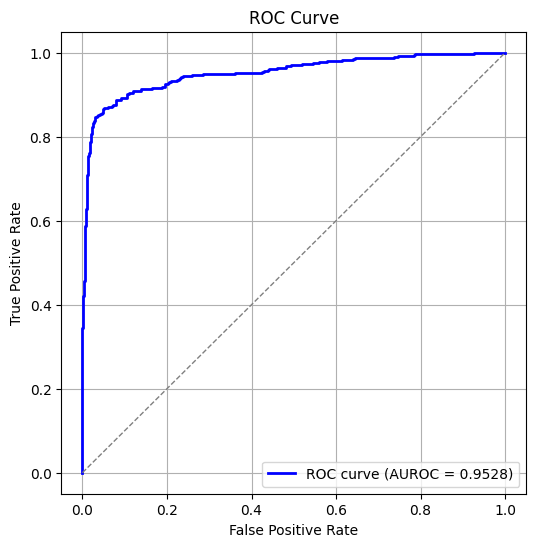

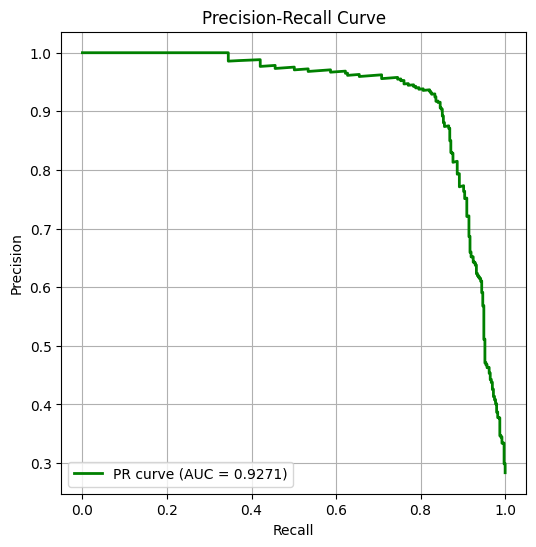

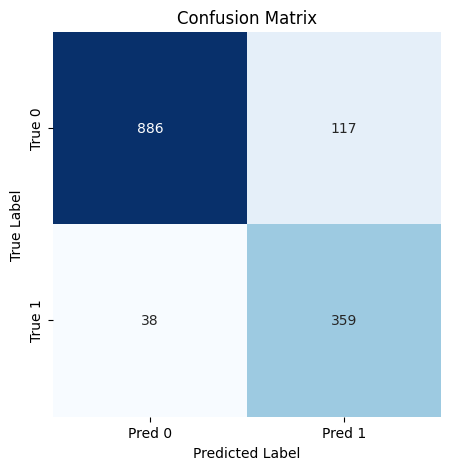

In [ ]:
import torch
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# ----------------------------
# 1. Load best model
# ----------------------------
best_model_path = "/content/best_fvnet.pth"
model.load_state_dict(torch.load(best_model_path))
model.to(device)
model.eval()

# ----------------------------
# 2. Collect predictions
# ----------------------------
all_preds = []
all_labels = []

with torch.no_grad():
    test_bar = tqdm(test_loader, desc="Evaluating on Test Set")
    for imgs, metadata, labels in test_bar:
        imgs, metadata, labels = imgs.to(device), metadata.to(device), labels.to(device)
        P_study, PL, PR, F_L, F_R = model(imgs, metadata)

        all_preds.append(P_study.sigmoid().cpu())
        all_labels.append(labels.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

# ----------------------------
# 3. Compute metrics
# ----------------------------
threshold = 0.5
pred_labels = (all_preds > threshold).astype(int)

test_acc = (pred_labels == all_labels).mean()
test_roc = roc_auc_score(all_labels, all_preds)
test_prec = precision_score(all_labels, pred_labels)
test_rec = recall_score(all_labels, pred_labels)
test_f1 = f1_score(all_labels, pred_labels)
cm = confusion_matrix(all_labels, pred_labels)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUROC: {test_roc:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall: {test_rec:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print("Confusion Matrix:")
print(cm)

# ----------------------------
# 4. Plot ROC Curve
# ----------------------------
fpr, tpr, _ = roc_curve(all_labels, all_preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUROC = {roc_auc:.4f})')
plt.plot([0,1], [0,1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# ----------------------------
# 5. Plot Precision-Recall Curve
# ----------------------------
precision, recall, _ = precision_recall_curve(all_labels, all_preds)
pr_auc = auc(recall, precision)

plt.figure(figsize=(6,6))
plt.plot(recall, precision, color='green', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

# ----------------------------
# 6. Confusion Matrix Heatmap
# ----------------------------
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred 0','Pred 1'], yticklabels=['True 0','True 1'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()
